<a href="https://colab.research.google.com/github/vitoria-assumpcao/Projetos-Segmentacao-Imagens/blob/main/Aprendizado-SM/Implementa_SM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  A deep neural Network utilizada nesse contexto segue estratégias Encoder-Decoder para segmentação semântica.
  Nesse caso, a U-Net combina a arquitetura encoder-decoder com Convolution Neural Network e utiliza skip connections para preservar informações espaciais e melhorar a segmentação.

importa uma biblioteca de aprendizado de máquina do próprio tensorflow:


In [1]:
!pip install git+https://github.com/tensorflow/examples.git


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-rqje5u9z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-rqje5u9z
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=d20e29bb36208706a0e7ca6813cbaa681307b1b97740acac80f1f39b8d77b6f2
  Stored in directory: /tmp/pip-ephem-wheel-cache-n_aeerwx/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


Importando as ferramentas que serão utilizadas da biblioteca:

In [2]:
import tensorflow as tf

import tensorflow_datasets as tfds



In [3]:
from tensorflow_examples.models.pix2pix import pix2pix  #pix2pix é ferramenta de machine learning utilizada

from IPython.display import clear_output
import matplotlib.pyplot as plt

Próximo passo é baixar o banco de dados utilizado para realizar a segmentação, nesse caso será utilizado o Oxford-IIIT Pets, que utiliza imagens de
gatos e cachorros para fazer a segmentação.

Disponível no dataset do TensorFlow:

In [5]:
dataset_builder = tfds.builder('oxford_iiit_pet', version='4.0.0') #construtor para acessar o dataset
dataset_builder.download_and_prepare()                             #baixa localmente o dataset

import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', split='train', with_info=True, as_supervised=True)                         #otimização
info = dataset_builder.info                                        #Pegamos as informações do dataset

# Visualizar as informações do dataset
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

**Código antigo:

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Esse bloco de código original estava dando problema na versão 3 utilizada.



Pixels serão definidos entre 0 e 1.
Além disso, as mascáras são definidas em um intervalo de 0 a 2, classificando cada parte da imagem (fundo, objeto, etc).

Por usar uma FCNN, precisará desses rótulos, justamente por conta da segmentação pixel-wise.

Normalizando a imagem e definindo máscara:

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0  #normalizando para pixels 0 e 1
  input_mask -= 1                                         #definindo máscara (0,1,2)
  return input_image, input_mask

0= pixel fundo

1= pixel animal de estimação

2= pixel bordas do animal

função para normalizar definida como 'normalize'

 Em redes convolucionais é importante padronizar a dimensão para melhor leitura das batches (lotes de imagens) para operar sobre um grid de pixels consistente.

Carregando a imagem e redimensionando ela e a máscara para um tamanho fixo:

In [7]:
def load_image(datapoint):                                       #garante formato adequado para ler a imagem
  input_image = tf.image.resize(datapoint['image'], (128, 128))  # redimensiona as imagens para entrar com valor fixo de 128x128
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],                              #redimensiona as máscaras para o mesmo das imagens
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,             #método para evitar interpolação de valores não inteiros, preservando o 0 e 1 definido anteriormente)
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Info vem do dataset carregado acima, que contém informações sobre as divisões do dataset (treino, validação e testes)

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples #variavel ira armazenar o numero de exemplos
BATCH_SIZE = 64                                  #definição de quantidade de exemplos utilizados em cada iteração do treinamento
BUFFER_SIZE = 1000                               #embaralhamento de exemplos
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE     #numero de passos por iteração (numero total de exemplos/batch size (exemplos por iteração))

  Como setamos as variáveis para o treinamento, agora iremos definir a função do treino:

In [12]:
(train_data, test_data), info = tfds.load(
    'oxford_iiit_pet',
    split=['train', 'test'],
    as_supervised=False,  # ou True, dependendo do que você espera no `load_image`
    with_info=True
)

def train_generator():   #define a função de treinamento do conjunto de imagens (mais otimização computacional)
     for datapoint in train_data:       # Itera sobre os dados
        yield load_image(datapoint)           #CADA CONJUNTO DE LOAD_IMAGE do dataset train SERÁ REDIMENSIONADO E NORMALIZADO

# Função geradora para o test dataset (também mais para a otimiação, porém do conjunto de teste)
def test_generator():
    for datapoint in test_data:         #Mesma coisa das funções de cima porém para o conjunto de imagens dos testes
        yield load_image(datapoint)

# Criar datasets eficientes com from_generator() para o TRAIN
train_images = tf.data.Dataset.from_generator(
    train_generator,
    output_signature=(                         #irá gerar os dados sob demanda (redução de uso computacional)
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),  #define a estrutura de entrada dos dados (igual da função de normalize)
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
    )
)

# Criar datasets eficientes com from_generator() para o TEST
test_images = tf.data.Dataset.from_generator(
    test_generator,
    output_signature=(
        tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.float32),
    )
)

# Verificar se tudo foi carregado corretamente
for image, mask in train_images.take(1).as_numpy_iterator():
    print(image.shape, mask.shape)

(128, 128, 3) (128, 128, 1)


**o código antigo:

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

E estava dando erro por conta dos tipos das variáveis, pois o dataset ['train'] vem de as_data_source que retorna arrayRecordDataSource e não suporta o método .map que funciona apenas com tf.data.Dataset (no TensorFlow).

Então utilizamos o from_generator() que converte o dataset para o formato correto

Criação de classe personalizada de augmentation de imagens como uma nova layer dentro da rede neural, cria operação de RandomFlip em horizontal:

In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()

    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)  #aplicações de operações RandomFlip para ambos imagem e máscara

  def call(self, inputs, labels):     #defini função para chamar as alterações da operação randomflip (comportamento do método)
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)

    return inputs, labels             #retorna com as versões modificadas

 Realizar o procedimento de data augmentation mantém um padrão de desempenho melhor ao criar variações a partir da imagem original criando labels mais eficientes.

Criando pipelines de dados para treinamento e validação do modelo:

In [14]:
train_batches = (                                  #treinamento das iterações (instruções para as entradas no TRAIN)
    train_images
    .cache()                                       #armazena em dataset
    .shuffle(BUFFER_SIZE)                          #embaralha os dados
    .batch(BATCH_SIZE)                             #define tamanho dos lotes estudados por iteração
    .repeat()                                      #repete até o limite definido de epochs (iterações)
    .map(Augment())                                #chama a função de aumento de dados definida acima
    .prefetch(buffer_size=tf.data.AUTOTUNE))       #prepara o próximo lote enquanto o modelo treina pela iteração atual (permite que a pipeline seja executada de forma assíncrona)

test_batches = test_images.batch(BATCH_SIZE)       #dados do teste definidos pelo tamanho do lote por iteração

Função para mostrar a imagem original e a máscara definida a partir do treinamento:

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))                            #define a dimensão da imagem para mostrar para 15x15

  title = ['Input Image', 'True Mask', 'Predicted Mask']  #título de cada imagem

#Para organizar a distribuição das imagens na visualização
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

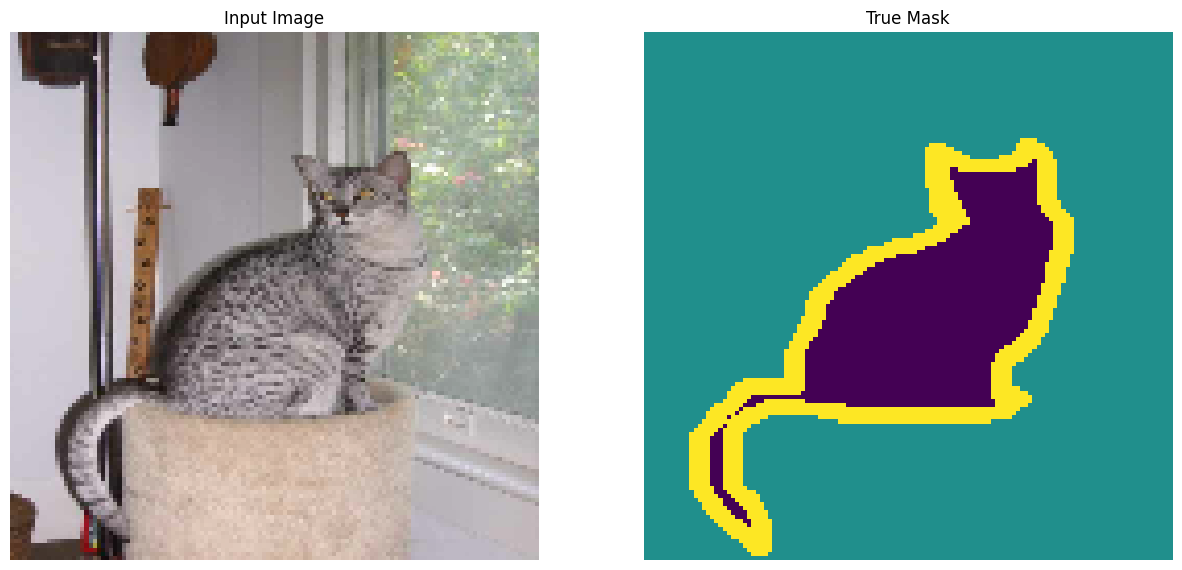

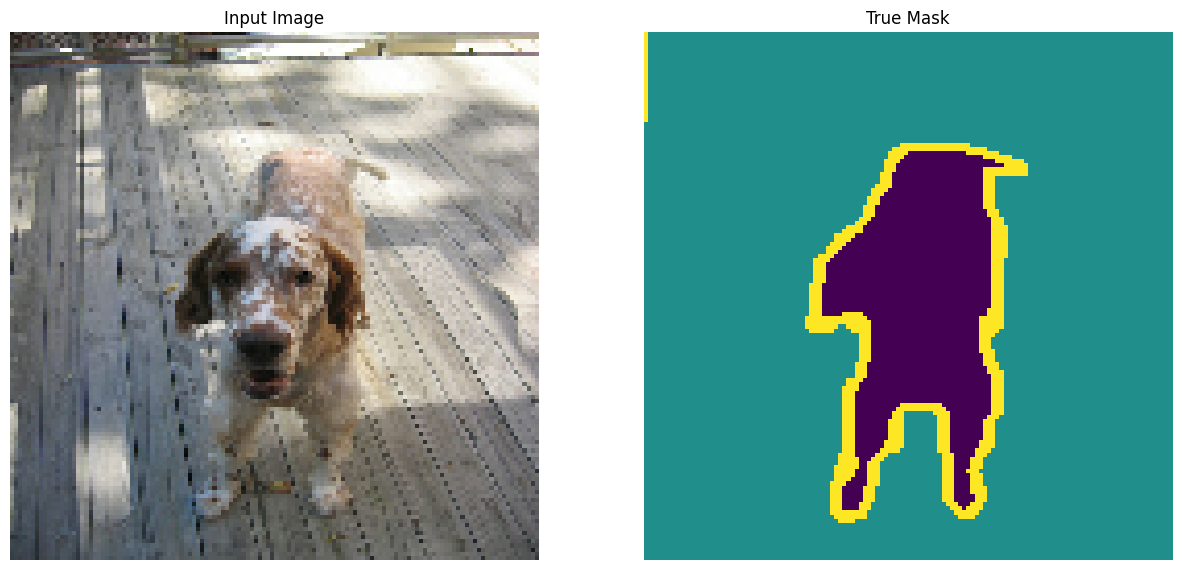

In [16]:
for images, masks in train_batches.take(2):           #define quantas imagens vão ser mostradas para visualização das máscaras
  sample_image, sample_mask = images[0], masks[0]     #loop para mostrar a imagem e máscara referente
  display([sample_image, sample_mask])

Os dados de teste são usados apenas para avaliar a performance do modelo. Durante essa avaliação, o modelo gera as máscaras previstas com base nas imagens de teste (input) e essas máscaras previstas são comparadas com as true masks (máscaras reais) que estão associadas às imagens de teste.

Configuração da parte encoder da U-Net modificada:

In [17]:
#Utiliza modelo de rede neural MobileNetV2 (rede convolucional) para extração de características da imagem sem usar a parte de classificação
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64      #Extrai caracteristicas de nível baixo das camadas convlucionais
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4        #downsampling realizado para extrair caracteristicas complexas da imagem
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]   #pega a saída da extração de características para a parte encoder

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False  #as camadas não serão atualizadas durante o treinamento (irá aprender a partir do decoder)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Modelo U-Net construído a partir de upsampling e skip connections (parte decoder para gerar a máscara de segmentação):

In [18]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64           #upsampling para a parte decoder
]

In [19]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])     #define a entrada

  # Downsampling pelo modelo
  skips = down_stack(inputs)                              #skips contém valores das saídas das camadas de convolução, extraindo feature maps de diferentes resoluções
  x = skips[-1]                                           #última camada convolucional é a utilizada no decoder armazenada na variavel X.
  skips = reversed(skips[:-1])                            #as outras camadas de convolução serão guardadas em ordem reversa para serem utilizadas nas skip connections do decoder.

  # Upsampling e estabeleciomento de skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])                                 #concatenação das outras camadas para o skip connection

  # Deconvolução e restauração da imagem ao original
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')                                     #strides=2 = 64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)        #geração do modelo final

Compilação do modelo U-Net:

In [20]:
OUTPUT_CLASSES = 3                                       #definição de saída das 3 classes definidas na normalização do início para a máscara de segmentação

model = unet_model(output_channels=OUTPUT_CLASSES)       #chama a função que definiu a U-Net como parametro de saida as classes definidas
model.compile(optimizer='adam',                          #compilação do código: otimização, loss function e métricas (Adaptive Moment Estimation)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])                      #a métrica a ser seguida vai ser acurácia quanto a true mask

Visualização gráfica da arquitetura do modelo de rede neural, representando as conexões das camadas:

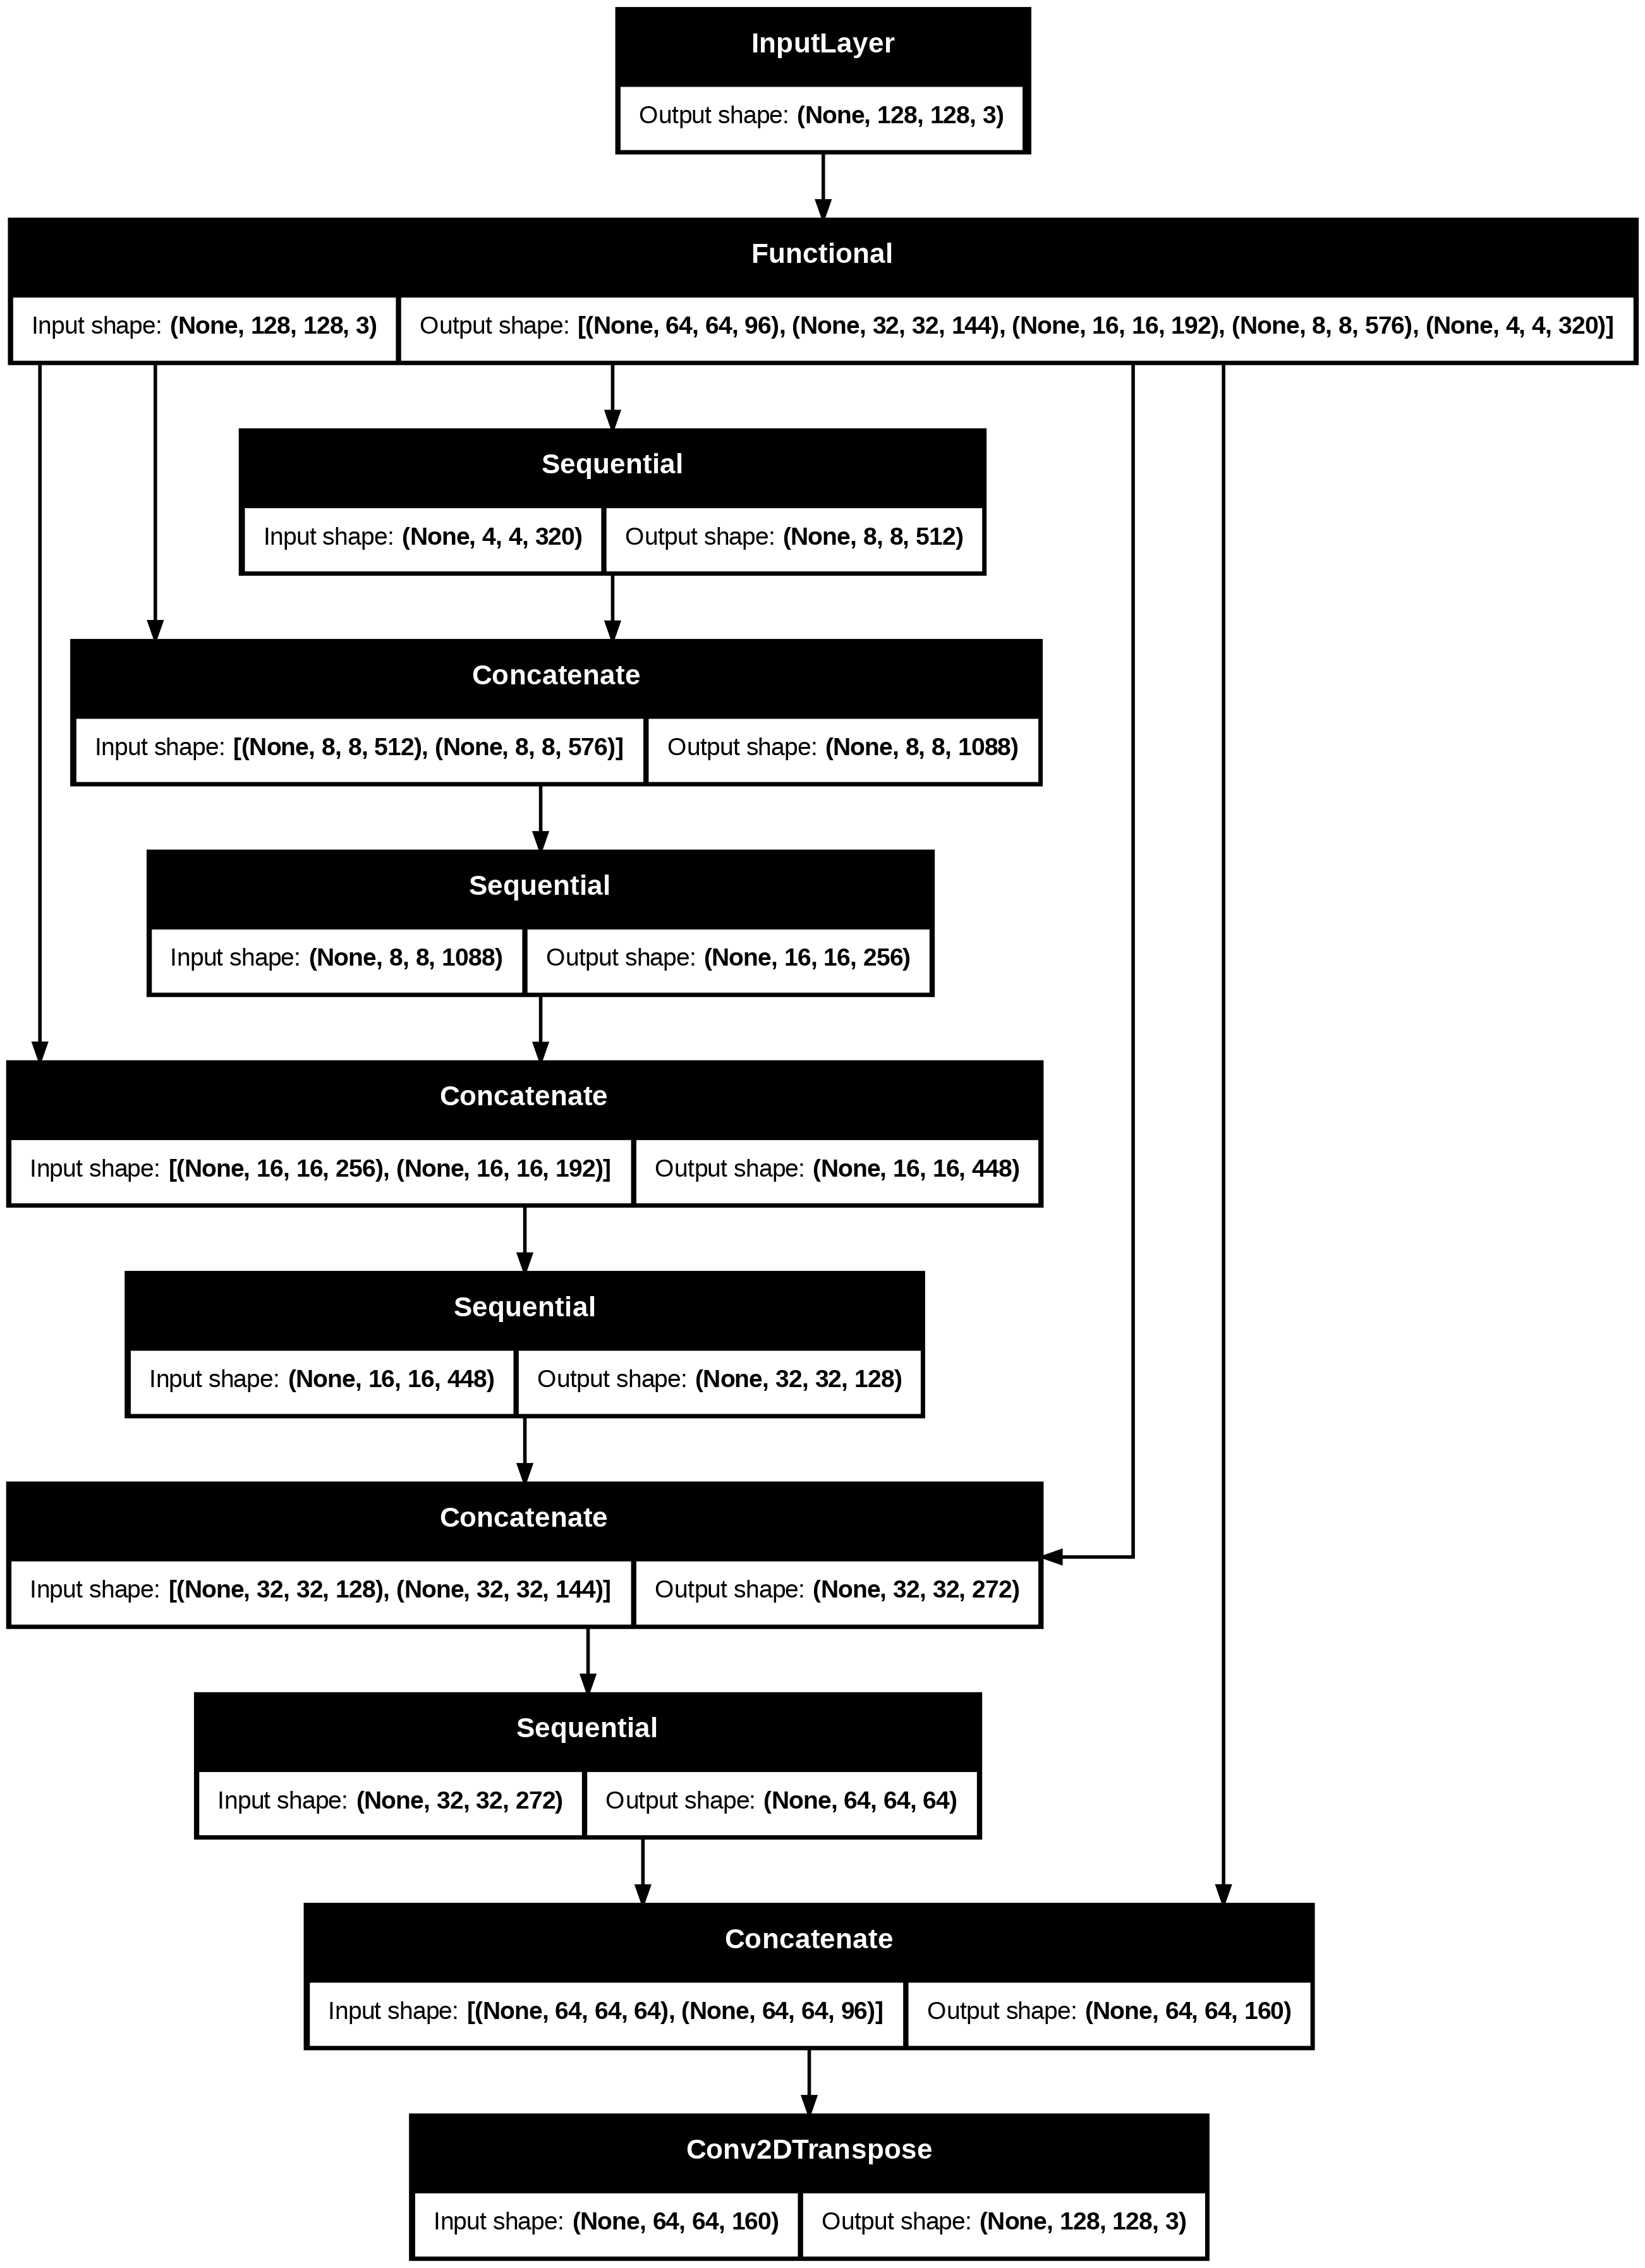

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

Treinar o modelo para ver se a máscara prevista está saindo ok:

In [22]:
def create_mask(pred_mask):                        #função para definir a máscara prevista
  pred_mask = tf.math.argmax(pred_mask, axis=-1)   #o método argmax retorna a classe de maior probabilidade por pixel (entrada máscara prevista gerada pelo modelo)
  pred_mask = pred_mask[..., tf.newaxis]           #defini a máscara para [128,128,1]
  return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):                          #define  a visualização da máscara prevista em relação a imagem original e true mask
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


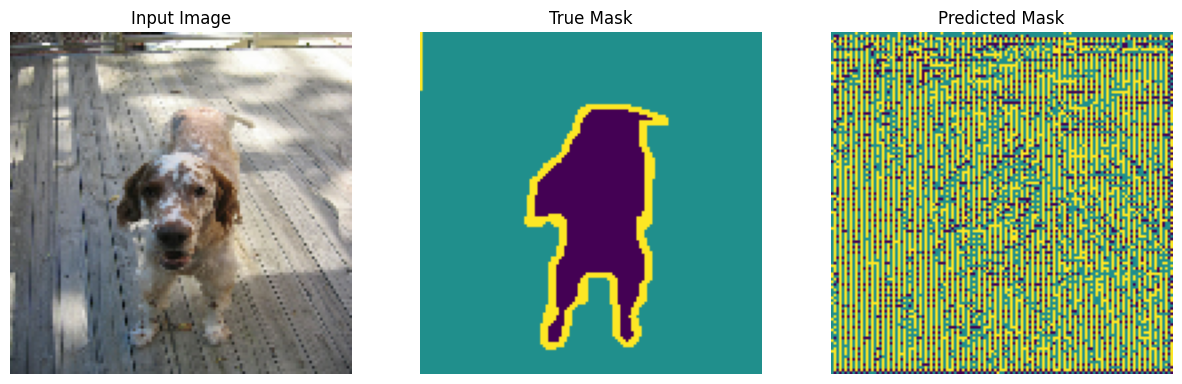

In [24]:
show_predictions()

Visualização e treinamento do modelo para gerar as predicteds masks:

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):                   #callback vai definir a chamadas de pontos específicos para cada iteração definida
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)                                            #limpa console em cada iteração
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


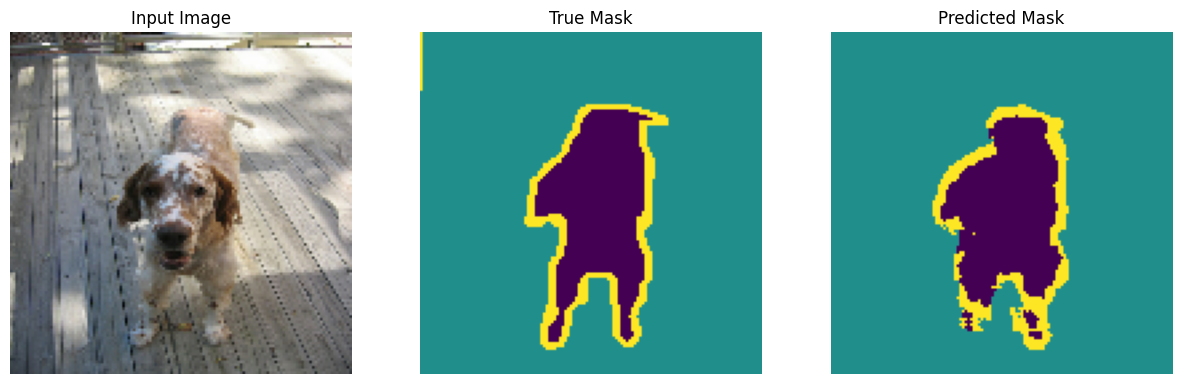


Sample Prediction after epoch 15

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9225 - loss: 0.1910 - val_accuracy: 0.9061 - val_loss: 0.2579


In [27]:
EPOCHS = 15                          #definição do número de iteração para o treinamento da predicted mask (cada uma com o numero de batches definido anteriormente)
VAL_SUBSPLITS = 5                    # subdivide os dados de validação em 5 partes
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS #calcula quantos lotes serão ´rpcessados na validação de cada iteração (validação).

model_history = model.fit(train_batches, epochs=EPOCHS,       #inicia o treinamento do modelo pelas instruções definidas anteriormente
                          steps_per_epoch=STEPS_PER_EPOCH,    #train_batches=conjunto de dados de treinamento, etc
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

Análise da perca de precisão do treinamento após cada iteração do treinamento:

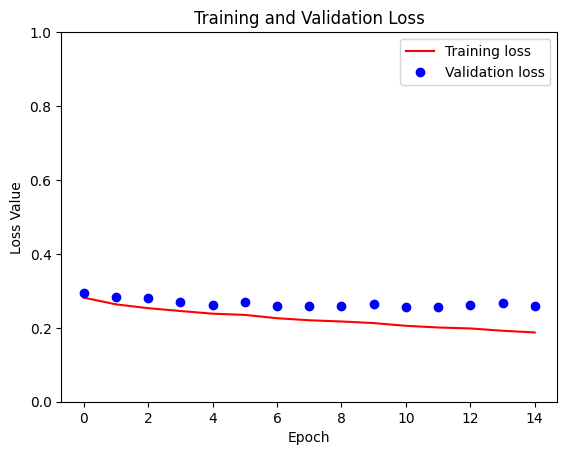

In [28]:
loss = model_history.history['loss']                       #perda após cada iteração
val_loss = model_history.history['val_loss']

#plotagem de um gráfica da perca de precisão por iteração
plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

A U-Net tem um grande problema de perca de características abstratas após muitas iterações, por conta de skip connections muito restritivas ocasionam o acúmulo de features sem muitas variações.

Exibe as previsões do modelo pelo conjunto de dados de teste (utilizado para comparar resultados e medir precisão do modelo):

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step


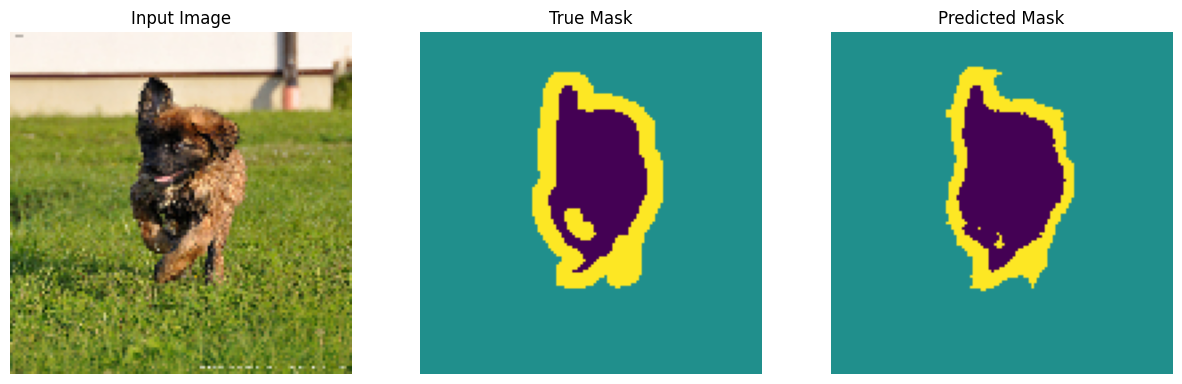

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


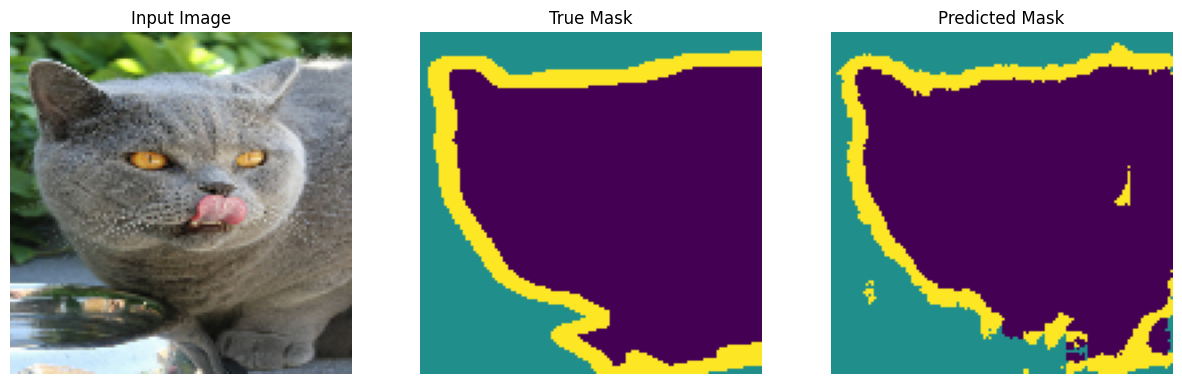

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


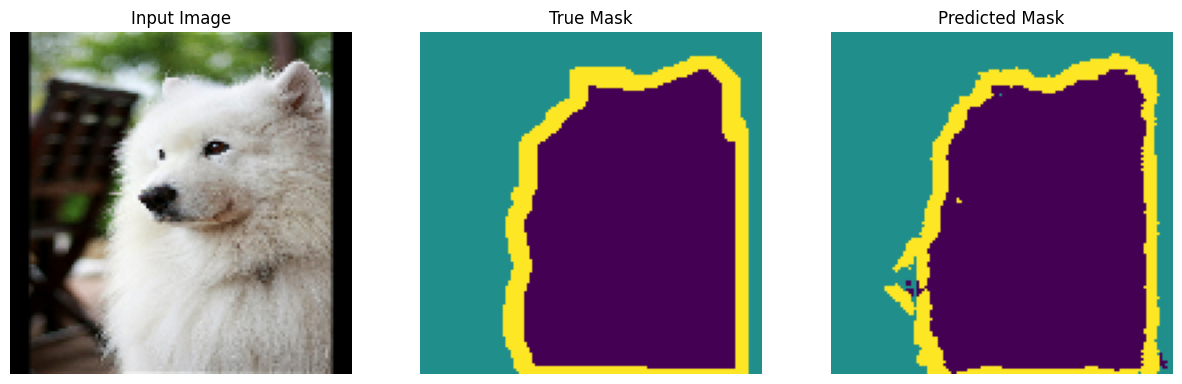

In [29]:
show_predictions(test_batches, 3)

No treinamento: O modelo tenta prever as máscaras com base nas imagens de entrada. As previsões são comparadas com as máscaras reais para ajustar os parâmetros do modelo.

Nos dados de teste: O modelo faz previsões (máscaras previstas) e essas previsões são comparadas com as máscaras reais para avaliar o desempenho do modelo, mas sem alterar os parâmetros.